In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import keras_tuner as kt
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import wfdb
import random

### Load Data

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = "/Users/danielkim/Documents/MIDS/W207-ML/Final/Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100

Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: x[0] if len(x) > 0 else 'NORM')

In [4]:
X[0][13] # First example

array([-0.115, -0.028,  0.086,  0.071, -0.1  ,  0.029, -0.059, -0.011,
        0.018,  0.015,  0.01 , -0.058])

In [5]:
y = Y['diagnostic_superclass'].to_numpy()
classes, counts = np.unique(y, return_counts=True)
classes, counts # Don't end up with same counts each time - fix?

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([2036, 1618, 5469, 9917, 2759]))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [7]:
y_train.shape

(17439,)

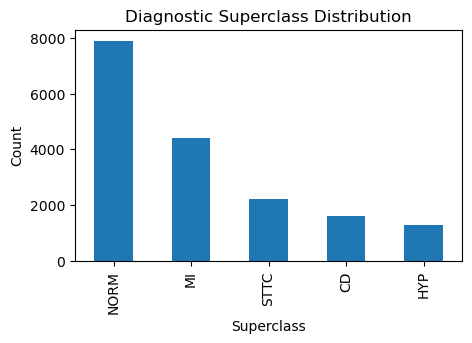

In [8]:
plt.figure(figsize=(5,3))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

In [9]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
print(train_classes, train_counts)

['CD' 'HYP' 'MI' 'NORM' 'STTC'] [1620 1294 4422 7902 2201]


### Correct Data Imbalance

In [10]:
smallest_class_count = min(train_counts)
print(smallest_class_count)

1294


In [11]:
def get_class_subset(ekg_class):
    y_train_class_indices = np.where(y_train == ekg_class)[0]
    y_train_class_subset_indices = np.random.choice(
        y_train_class_indices,
        size=smallest_class_count,
        replace=False
    )
    X_train_class_subset = X_train[y_train_class_subset_indices]
    y_train_class_subset = np.array([ekg_class] * smallest_class_count)
    return X_train_class_subset, y_train_class_subset

X_train_cd, y_train_cd = get_class_subset('CD')
X_train_hyp, y_train_hyp = get_class_subset('HYP')
X_train_mi, y_train_mi = get_class_subset('MI')
X_train_norm, y_train_norm = get_class_subset('NORM')
X_train_sttc, y_train_sttc = get_class_subset('STTC')

In [12]:
print(X_train_cd.shape)
#print(X_train_hyp.shape)
#print(X_train_mi.shape)
#print(X_train_norm.shape)
#print(X_train_sttc.shape)

(1294, 1000, 12)


In [13]:
X_train = np.concatenate((X_train_cd, X_train_hyp, X_train_mi, X_train_norm, X_train_sttc))
X_train.shape

(6470, 1000, 12)

In [14]:
#print(y_train_cd.shape)
#print(y_train_hyp.shape)
#print(y_train_mi.shape)
#print(y_train_norm.shape)
#print(y_train_sttc.shape)

In [15]:
y_train = np.concatenate((y_train_cd, y_train_hyp, y_train_mi, y_train_norm, y_train_sttc))
y_train.shape

(6470,)

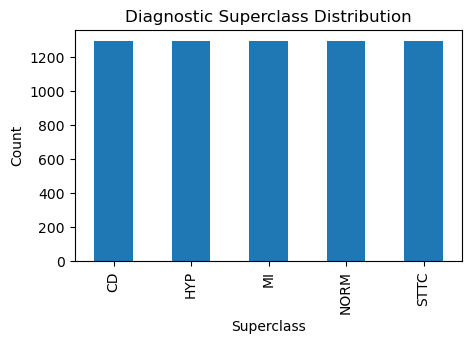

In [16]:
plt.figure(figsize=(5,3))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

### Split Data

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

In [18]:
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (5176, 1000, 12)
Training labels shape: (5176,) 

Validation data shape: (1294, 1000, 12)
Validation labels shape: (1294,) 

Test data shape: (4360, 1000, 12)
Test labels shape: (4360,)


### Normalize Data

In [19]:
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-20.032 10.24


In [20]:
#def normalize(data):
#    data_mean = data.mean()
#    data_sd = data.std()
#    return (data - data_mean) / data_sd

#X_train = normalize(X_train)
#X_val = normalize(X_val)
#X_test = normalize(X_test)

In [21]:
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-20.032 10.24


### Baseline Models

Training accuracy: 0.18875579598145287
Validation accuracy: 0.18856259659969088
Test accuracy: 0.20229357798165137


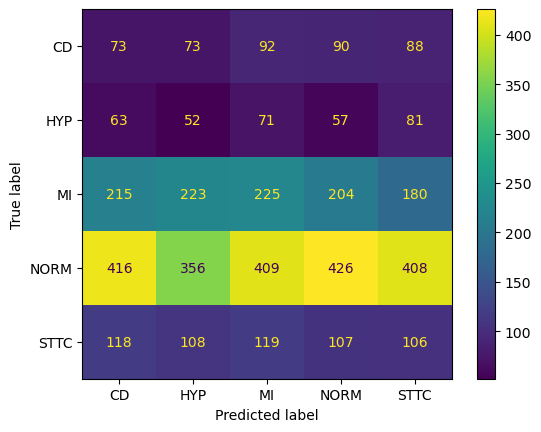

In [22]:
def random_classification(training_data):
    return [np.random.choice(classes) for _ in training_data]

predictions_train = random_classification(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = random_classification(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = random_classification(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

random_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=random_cm, display_labels=train_classes).plot();

Training accuracy: 0.19938176197836166
Validation accuracy: 0.20247295208655333
Test accuracy: 0.46215596330275227


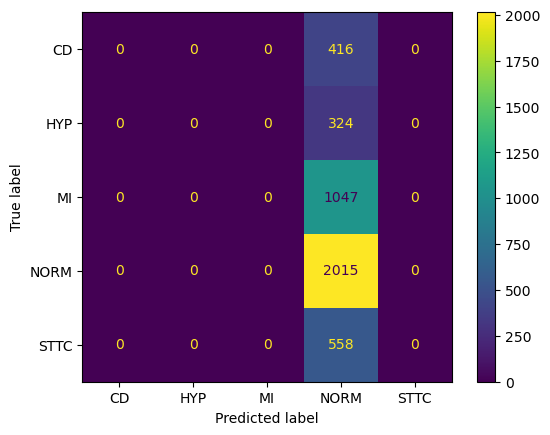

In [23]:
def always_classify_normal(training_data):
    return ['NORM'] * len(training_data)

predictions_train = always_classify_normal(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = always_classify_normal(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = always_classify_normal(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

normal_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=normal_cm, display_labels=train_classes).plot();

### Train Models

In [24]:
X_train_flattened = np.array([ekg.flatten() for ekg in X_train])
print(X_train_flattened.shape)

X_val_flattened = np.array([ekg.flatten() for ekg in X_val])
print(X_val_flattened.shape)

X_test_flattened = np.array([ekg.flatten() for ekg in X_test])
print(X_test_flattened.shape)

(5176, 12000)
(1294, 12000)
(4360, 12000)


**Neural Network**

In [25]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

In [26]:
model = models.Sequential()
model.add(layers.Normalization(axis=-1))
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(1000, 13)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1)

model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])
# model.summary()

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
test_accuracy

Epoch 1/10


2024-04-16 23:34:00.869742: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


162/162 [==============================] - 13s 77ms/step - loss: nan - categorical_accuracy: 0.3823 - val_loss: nan - val_categorical_accuracy: 0.4034
Epoch 2/10
162/162 [==============================] - 11s 71ms/step - loss: nan - categorical_accuracy: 0.3991 - val_loss: nan - val_categorical_accuracy: 0.4034
Epoch 3/10
162/162 [==============================] - 12s 72ms/step - loss: nan - categorical_accuracy: 0.3991 - val_loss: nan - val_categorical_accuracy: 0.4034
Epoch 4/10
162/162 [==============================] - 12s 76ms/step - loss: nan - categorical_accuracy: 0.3991 - val_loss: nan - val_categorical_accuracy: 0.4034
Epoch 5/10
162/162 [==============================] - 12s 75ms/step - loss: nan - categorical_accuracy: 0.3991 - val_loss: nan - val_categorical_accuracy: 0.4034
Epoch 6/10
162/162 [==============================] - 12s 77ms/step - loss: nan - categorical_accuracy: 0.3991 - val_loss: nan - val_categorical_accuracy: 0.4034
Epoch 7/10
162/162 [===================

0.2233944982290268